In [1]:
pip install d2l

     |████████████████████████████████| 83 kB 1.4 MB/s 


6.2图像卷积

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
#自定义卷积
def corr2d(X, K):
  h, w = K.shape
  Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i][j] = (X[i:i + h, j:j + w] * K).sum()
  return Y
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
#自定义卷积层
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Paeameter(torch.zeros(1))
  def forward(self, x):
    return corr2d(x, self.weight) + self.bias

In [ ]:
#学习卷积核——目标检测
X = torch.ones((6, 8))
X[:, 2: 6] = 0
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
conv2d = nn.Conv2d(1, 1, kernel_size = (1, 2), bias = False)
X =X.reshape(1,1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)
for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y)**2
  conv2d.zero_grad()
  l.sum().backward()
  conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
  if(i + 1) % 2 == 0:
    print(f'batch{i + 1}, loss {l.sum() : .3f}' )

batch2, loss  9.777
batch4, loss  1.662
batch6, loss  0.288
batch8, loss  0.052
batch10, loss  0.010


In [ ]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9787, -0.9890]])

In [ ]:
#1 * 1 卷积
def corr2d_multi_in_out_1x1(X, k):
  c_i, h, w = X.shape
  c_o = k.shape[0]
  X = X.reshape((c_i, h * w))
  K = K.reshape((c_o, c_i))
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

In [ ]:
#池化
import torch
from torch import nn
from d2l import torch as d2l
def pool2d(X, pool_size, mode = 'max'):
  p_h, p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i, j] = X[i:i + p_h, j:j + p_w].max()
      elif mode == 'avg':
        Y[i, j] = X[i:i + p_h, j:j + p_w].mean()
  return Y
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
print(pool2d(X, (2, 2)))
pool2d(X, (2, 2), 'avg')

tensor([[4., 5.],
        [7., 8.]])


tensor([[2., 3.],
        [5., 6.]])

对于给定输入元素，最大汇聚层会输出该窗口内的最大值，平均汇聚层会输出该窗口内的平均值。

汇聚层的主要优点之一是减轻卷积层对位置的过度敏感。

我们可以指定汇聚层的填充和步幅。

使用最大汇聚层以及大于 1 的步幅，可减少空间维度（如高度和宽度）。

汇聚层的输出通道数与输入通道数相同。

In [ ]:
#LeNet
import torch
from torch import nn
from d2l import torch as d2l
class Reshape(torch.nn.Module):
  def forward(self, X):
    return X.view(-1, 1, 28, 28)
net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size = 5, padding = 2),
                          nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size = 2, stride = 2),
                          nn.Conv2d(6, 16, kernel_size = 5),
                          nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size = 2, stride = 2),
                          nn.Flatten(),
                          nn.Linear(16 * 5 *5, 120),
                          nn.Sigmoid(),
                          nn.Linear(120, 84),
                          nn.Sigmoid(),
                          nn.Linear(84, 10))

In [ ]:
X = torch.rand(size = (1, 1, 28, 28), dtype = torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
batch_size= 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size = batch_size)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device = None):
  if isinstance(net, torch.nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)
  for X, y in data_iter:
    if isinstance(X, list):
      X = [x.to(device) for x in X]
    else:
      X = X.to(device)
    y = y.to(device)
    metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weight)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr = lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel = 'epoch', xlim = [1, num_epochs],
                          legend = ['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if(i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, 
                     (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f},'
     f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} example/sec'
     f'on {str(device)}') 

loss 0.454, train acc 0.830,test acc 0.829
44964.1 example/secon cuda:0


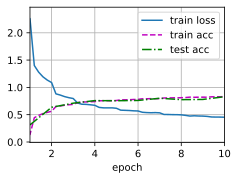

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())